# A Comprehensive Twitter US Airline Sentiment Analysis


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
#from plotnine import ggplot, aes, geom_line
#from PIL import Image

import re
import string
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
import warnings
%matplotlib inline

In [114]:
# Set images size
plt.rcParams["figure.figsize"] = (11,8);

# Set column print size to 140 characters to make sure that the tweets are
# fully printed - back in 2015 only 140 chars were allowed
pd.options.display.max_colwidth = 140

# ignore depreciation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [115]:
df = pd.read_csv('../Datasets/Tweets.csv')
df.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11427,568123193577177089,negative,1.0,Can't Tell,0.6623,US Airways,NaN,Twinscream1,NaN,0,@USAirways my number is 214-725-1966. CANT WAIT...LOL #usairsucks,NaN,2015-02-18 11:01:39 -0800,NaN,NaN
11637,567859601900740609,negative,1.0,Cancelled Flight,0.6314,US Airways,NaN,PastorMRobinson,NaN,0,"@USAirways flights keep getting delayed and Cancelled Flighted with no information, worst customer service ever.",NaN,2015-02-17 17:34:14 -0800,Lexington,Central Time (US & Canada)
13900,569692982955237377,negative,1.0,Cancelled Flight,0.6980,American,NaN,andresfreyesp,NaN,0,"@AmericanAir I have been trying to speak with an agent the whole day about my Cancelled Flightled flight, what I can do?",NaN,2015-02-22 18:59:26 -0800,NaN,Canberra
4601,569988842335244289,positive,1.0,NaN,NaN,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir Big kudos to your staff today at Dallas Love Field for lifting everyone's spirits today with all the delays and Cancelled ...,NaN,2015-02-23 14:35:04 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)


## Clean Data

In [116]:
# Some quick infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [117]:
# Let's print some of the tweets:
df['text'].head(100)

0                                                                                                       @VirginAmerica What @dhepburn said.
1                                                                  @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                   @VirginAmerica I didn't today... Must mean I need to take another trip!
3            @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                   @VirginAmerica and it's a really big bad thing about it
                                                                      ...                                                                  
95      @VirginAmerica Is it me, or is your website down?  BTW, your new website isn't a great user experience.  Time for another redesign.
96      @VirginAmeri

---

We need to clean a bit the tweets. To do so we remove:

1. Handles and mentions
2. Uppercases to lowercases
3. Punctuations, numbers and special characters
4. less than 4 chars words
5. URL's
6. Stopwords
7. Emojis


In [118]:
def clean_tweet(text):
    import contractions
    # fix contractions (such as didn't -> did not) und remove Uppercases
    text = contractions.fix(text).lower()
    # Remove mentions and URL's:
    text = re.sub(r"@\S+|https?://\S+", '', text )
    # Remove punctuations
    text = re.sub(r"\.|;|,|\*|_|\&|\?|=|\\|\+|\-|\(|\)|\…|\!|\"|:|\'|#|£|/", ' ', text)
    # Remove numbers
    text = re.sub(r"\d+", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if(word not in STOPWORDS and len(word)>1)]
    return " ".join(clean_words) 

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [119]:
# compare cleaned tweets with raw text
df['tweet_clean'] = df['text'].apply(clean_tweet).apply(remove_stopwords).apply(deEmojify)
df[['text', 'tweet_clean', 'airline_sentiment']].sample(10)

,text,tweet_clean,airline_sentiment
9042,.@USAirways I did but the more eyes I have looking for Pandu the better chance I have of bringing him home.,eyes looking pandu better chance bringing home,negative
11588,@USAirways your saving grace was our flight attendant Dallas who was amazing. wish he would transfer to Delta where I would see him again,saving grace flight attendant dallas amazing wish transfer delta see,negative
5739,@Southwestair is this account even aware of the #destinationdragons contest? The one youre fucking up for me?,account even aware destinationdragons contest one fucking,negative
12295,"@AmericanAir Yes, talked to them. FLL says is at central. Central says is at FLL and here we go again. I'm betting this will go 6 mths",yes talked fll says central central says fll go betting will go mths,negative
10365,@USAirways by far the worst airline in history. I'll never ever fly your garbage again,far worst airline history will never fly garbage,negative
4887,@SouthwestAir #RedCarpet Southwest Companion Pass would be great!,redcarpet southwest companion pass great,positive
13383,"@AmericanAir AA2334 Second week in a row delayed, due to mechanical issues. All the sleet outside and yet we're stuck changing a tire",aa second week row delayed due mechanical issues sleet outside yet stuck changing tire,negative
6752,@JetBlue check DM please :),check dm please,neutral
6919,"@JetBlue When chging flight, isit possible to pay the fare difference in dollars when the ticket was bought completely via point redempt...",chging flight isit possible pay fare difference dollars ticket bought completely via point redemption,neutral
11149,@USAirways @americanair I feel sorry for AA,feel sorry aa,negative


**NOTE:** One side-effect of text cleaning is that some rows do not have any words left in their text. That could cause errors later on specially when we are going to use the `Word2Vec` algorithm. There are different strategies we could apply to deal with these missing values:

* Remove the complete row, but in a production environment this is not really desirable.
* Keep words smaller than 4 characters and numbers
* Impute the missing value with some placeholder text like `no_text`

In [120]:
empty_clean = df['tweet_clean'] == ''
print('Indeed {} records have no words left after text cleaning'.format(df.loc[empty_clean]['tweet_clean'].count()))

Indeed 26 records have no words left after text cleaning


In [121]:
# Here are some examples:
df.loc[df['tweet_clean']=="", ['text', 'tweet_clean']].sample(5)

,text,tweet_clean
10776,@USAirways How do I get through?,
6947,@JetBlue @BucketObolts Same,
9255,"@USAirways should, but didn’t.",
2607,@united no u don't,
4612,@SouthwestAir Why do you have to be 18 😭,


In [122]:
# Let's drop the columns we don't need:
df = df.drop(['tweet_id','retweet_count', 'tweet_coord',
                               'tweet_location','name','user_timezone'],axis = 1)

In [123]:
pd.options.display.max_colwidth = 20
df.sample(5)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text,tweet_created,tweet_clean
868,neutral,0.6641,NaN,NaN,United,NaN,NaN,Decisions Decisi...,2015-02-23 18:16...,decisions decisi...
14630,positive,1.0000,NaN,NaN,American,NaN,NaN,@AmericanAir Tha...,2015-02-22 12:04...,thanks
1442,neutral,1.0000,NaN,NaN,United,NaN,NaN,@united UA1469. ...,2015-02-22 20:33...,ua landed
947,negative,0.6880,Can't Tell,0.6880,United,NaN,NaN,@united Just got...,2015-02-23 15:03...,got demoted gold...
2335,negative,0.6452,Can't Tell,0.3441,United,NaN,NaN,@united Such as ...,2015-02-21 14:04...,deodorant shampo...


## Exploratory Data Analysis (EDA)

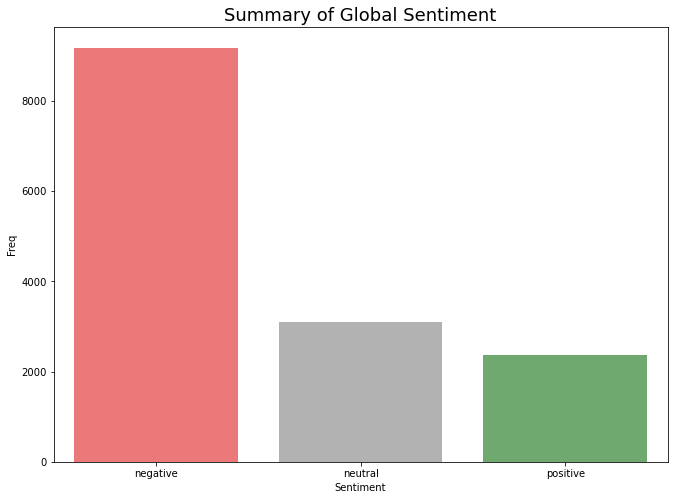

In [124]:
# summary of global sentiment
sns.set_palette("pastel")
sns.countplot(x=df['airline_sentiment'].sort_values() , 
              alpha=.6, 
              palette={'negative':'r', 
                       'neutral': 'grey', 
                       'positive': 'green'})
plt.ylabel('Freq')
plt.xlabel('Sentiment')
plt.title('Summary of Global Sentiment', fontsize=18);

In [125]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [126]:
# Tweets per airline in percent
tweets_per_airline = (df[['airline', 'text']].groupby('airline').count()/len(df['text'].notna().notnull())).sort_values(by='text', ascending=False)
tweets_per_airline

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


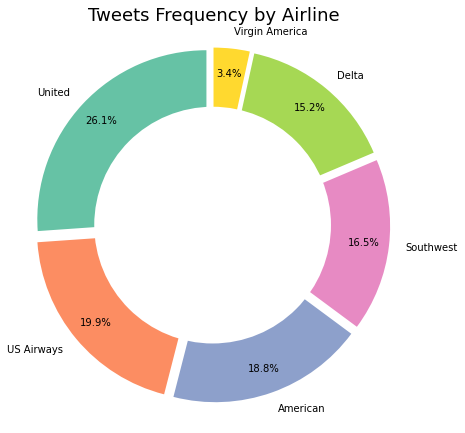

In [127]:
 
# Pie Chart of normalized tweets frequency for each airline
# Although, it is not recommended to use pie chart as visualization, 
# since they could be confusing and hard to understand, it doesn't hurt
# to learn how to do it

#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
colors = sns.color_palette('Set2',10)
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
plt.pie(tweets_per_airline.text, labels=tweets_per_airline.index.values, autopct='%1.1f%%', 
startangle=90, colors=colors,
pctdistance=0.85, explode = [0.05]*tweets_per_airline.shape[0])
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18,);

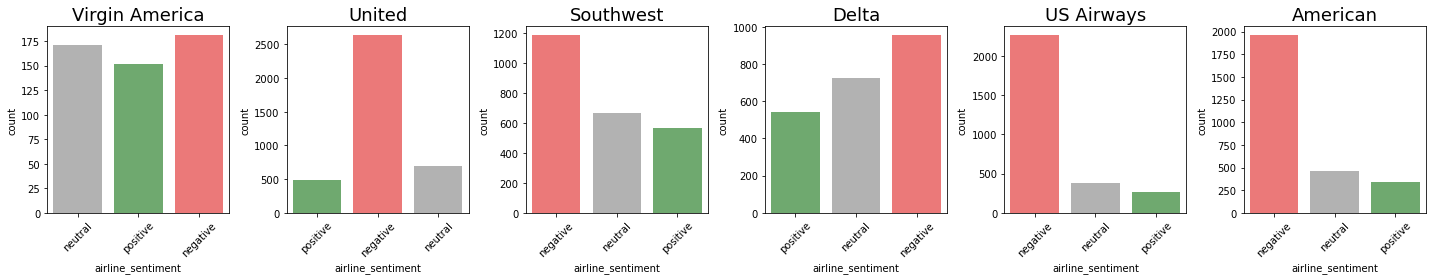

In [132]:
j=1

plt.subplots(figsize=(20,4),tight_layout=True)
for i in df["airline"].unique():
        x = df[df["airline"]==i]
        plt.subplot(1, 6, j)
        sns.countplot(x["airline_sentiment"], palette={'negative':'r', 
                       'neutral': 'grey', 
                       'positive': 'green'}, alpha=.6)
        plt.xticks(rotation=45)
        plt.title(i, fontsize=18)
        j +=1
plt.show();

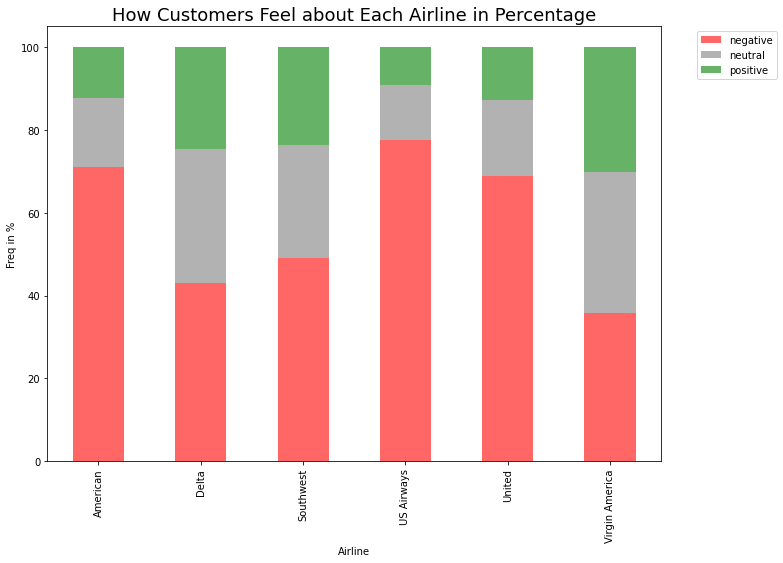

In [131]:
# Plot sentiment rates per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',
                title='How Customers Feel about Each Airline in Percentage', 
                stacked=True,
                color=['red', 'grey', 'green'], alpha=0.6 )

_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Freq in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

From the above figure we can already see that Virgin America has the best customer sentiment and US Airways the worst. Indeed, Virgin America was ranked as the second best US airline in the US in 2015 [[1]](https://www.airfarewatchdog.com/blog/23248943/best-u-s-airlines-2015-edition/), while US Airways the 8th or the second worst before United. However, it is important to put those numbers in relation to the total number of customers per carrier for the year 2015. Because what appears to be a large number can, once put into proportion, become really small. So we need to be careful about this kind of  conclusions. 
Nonetheless, knowing that Virgin America was ranked second best in the US in 2015 and best between 2012 and 2014 is a good starting point to understand, from the customer point of view, what makes it better than the rest depicted above.

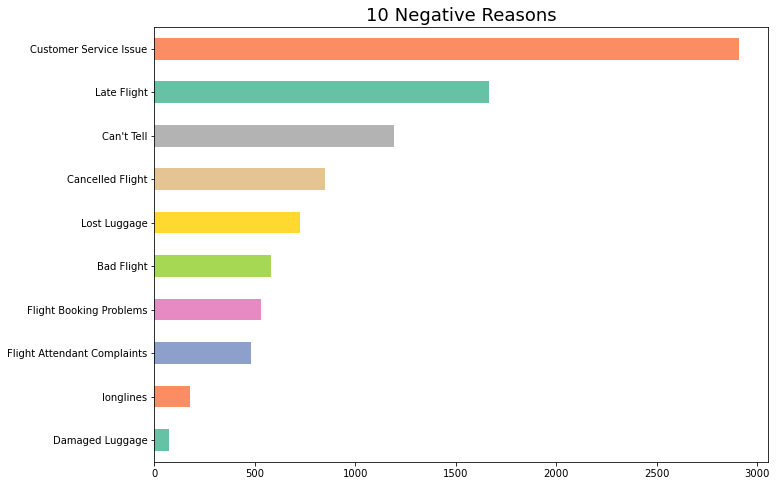

In [87]:
# Let's investigate more  the negative customer sentiments
colors = sns.color_palette('Set2',df['negativereason'].nunique())
df['negativereason'].value_counts().sort_values().plot(kind='barh', color=colors)
plt.title('10 Negative Reasons', fontsize=18,);

There are 10 different reasons for negative reviews. The most important ones are:

1. Customer Service Issue with almost 3000 tweets
2. Late flight (Nr of tweets= 1665)
3. Can't tell, which means the overall flight experience with more than 1100 tweets.

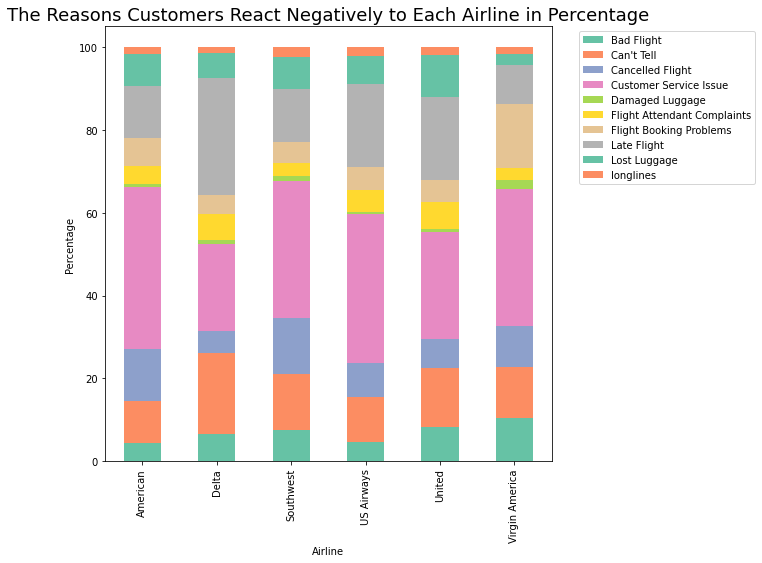

In [88]:
# Visualize negative reasons in percentage per airline
pd.crosstab(df.airline, df.negativereason).apply(lambda x: x/x.sum() * 100, axis=1).plot(kind="bar",color = colors,figsize=(8,8),stacked=True)
plt.title('The Reasons Customers React Negatively to Each Airline in Percentage', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Showing this kind of graph is all well and good, but it is important to connect each of these sources of negative reactions to the value chain of the company in question in order to determine the actions that need to be taken to increase customer satisfaction. 
After all, this kind of analysis only makes sense if it leads to effective actions.

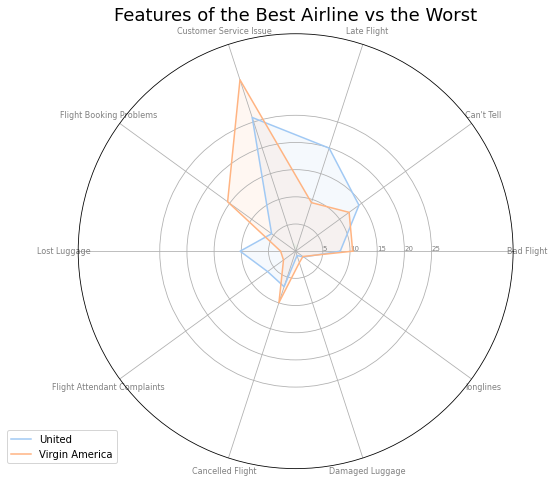

In [89]:
# Plot a radar chart with the negative reasons for three carriers
# Generate a dataframe with negative reasons rates per carrier for 3 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in ['United', 'Virgin America']:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

# number of variable
categories = list(neg_rev.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values


# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=7)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1.5, linestyle='solid', label=label)
# Fill area
ax.fill(angles, values, ['b', 'o', 'green'], alpha=0.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)

plt.title('Features of the Best Airline vs the Worst', fontsize=18,);
# Show the graph
plt.show()

It seems that travelers give much more importance to flight delays and lost luggages than to technical problems during online ticket booking.So to compete with best airline companies havee to improve thooses both variable.

Let's compare virgin america with delta, which is ranked as the third best and comes exactly after virgin for overall performance 


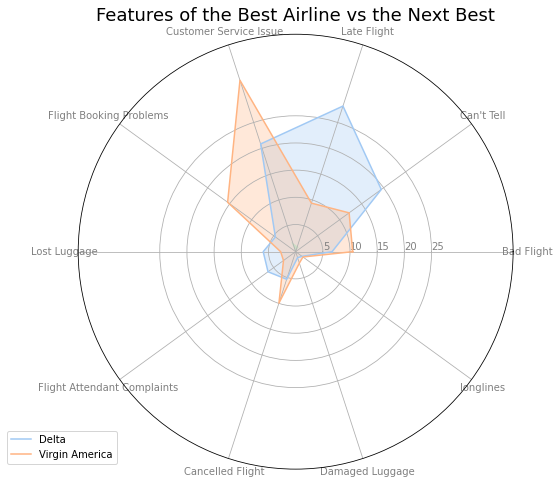

In [90]:
# Plot a radar chart with the negative reasons for three carriers
# Generate a dataframe with negative reasons rates per carrier for 3 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in ['Delta', 'Virgin America']:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

# number of variable
categories = list(neg_rev.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values


# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=10)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=10)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1.5, linestyle='solid', label=label)
# Fill area
ax.fill(angles, values, ['b', 'o', 'green'], alpha=0.3)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)

plt.title('Features of the Best Airline vs the Next Best', fontsize=18,);
# Show the graph
plt.show()

In [101]:

def generate_wordcloud(sentiment):
    """
    Generate a wordcloud fig from tweets given sentiment
    
    sentiment could be: 'negative', 'positive', 'all'
    """
    
    if sentiment == 'all':
        words = df['tweet_clean'].str.cat(sep=' ')
        stopwords = {}
    else:
        words = df[df['airline_sentiment']==sentiment]['tweet_clean'].str.cat(sep=' ')
    

    
    wordcloud = WordCloud(background_color='white',
                          width=400,
                          height=250,
                          min_font_size=8,
                          collocation_threshold=50,
                          max_words=500,
                         ).generate(words)
    plt.figure(1,figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(str.title(sentiment)+" Tweets", fontsize=18)
    plt.show()

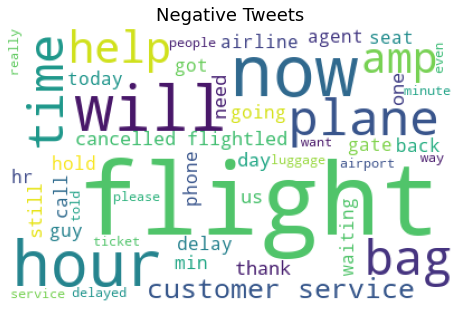

In [102]:
# most used words by negative sentiment 
generate_wordcloud('negative')

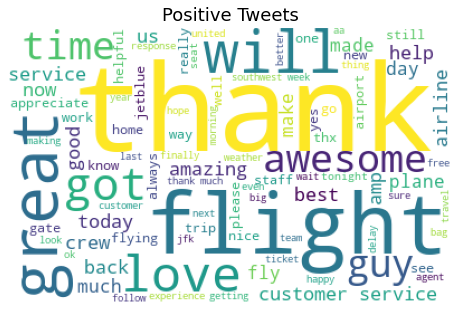

In [103]:
# most used words by positive sentiments
generate_wordcloud('positive')

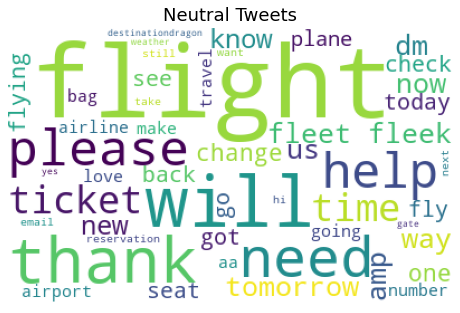

In [104]:
# most used words by positive sentiments
generate_wordcloud('neutral')

In [94]:
# replace NaN's with 0 or empty space:
df['negativereason'] = df['negativereason'].fillna('')
df['negativereason_confidence'] = df['negativereason_confidence'].fillna(0)
df['airline_sentiment_gold'] = df['airline_sentiment_gold'].fillna('')
df['negativereason_gold'] = df['negativereason_gold'].fillna('')

In [ ]:
# Tokenization
tweets_tokenized = df['tweet_clean'].apply(lambda x: x.split())

# Stemming
stemmer = PorterStemmer()
tweets_tokenized = tweets_tokenized.apply(lambda x: [stemmer.stem(i) for i in x])
tweets_tokenized.head()

In [ ]:
testdata = df[['negativereason', 'tweet_clean']].copy()